In [ ]:
import dynamiqs as dq
import jax.numpy as jnp

# Define Hilbert-space truncations (for example)
na = 20  # dimension for mode a
nb = 5   # dimension for mode b

# Define mode operators in the composite Hilbert space (mode a ⊗ mode b)
a    = dq.tensor(dq.destroy(na), dq.eye(nb))  # annihilation operator for mode a
adag = a.dag()                                # creation operator for mode a
b    = dq.tensor(dq.eye(na), dq.destroy(nb))   # annihilation operator for mode b
bdag = b.dag()                                # creation operator for mode b

# Define parameters (g2 and eps_d may be complex)
g2    = 1.0       # two-photon coupling constant (can be complex)
eps_d = -4.0     # drive amplitude (can be complex)

# Construct the two-photon part of the Hamiltonian:
# H^2ph = g2 * a†^2 * b + (g2)* * a^2 * b†
H_2ph = g2 * (adag @ adag @ b) + jnp.conjugate(g2) * (a @ a @ bdag)

# Construct the drive part of the Hamiltonian:
# H^d = eps_d* * b + eps_d * b†
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag

# Total Hamiltonian
H = H_2ph + H_d

|██████████| 100.0% ◆ elapsed 247.71ms ◆ remaining 0.00ms  


/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


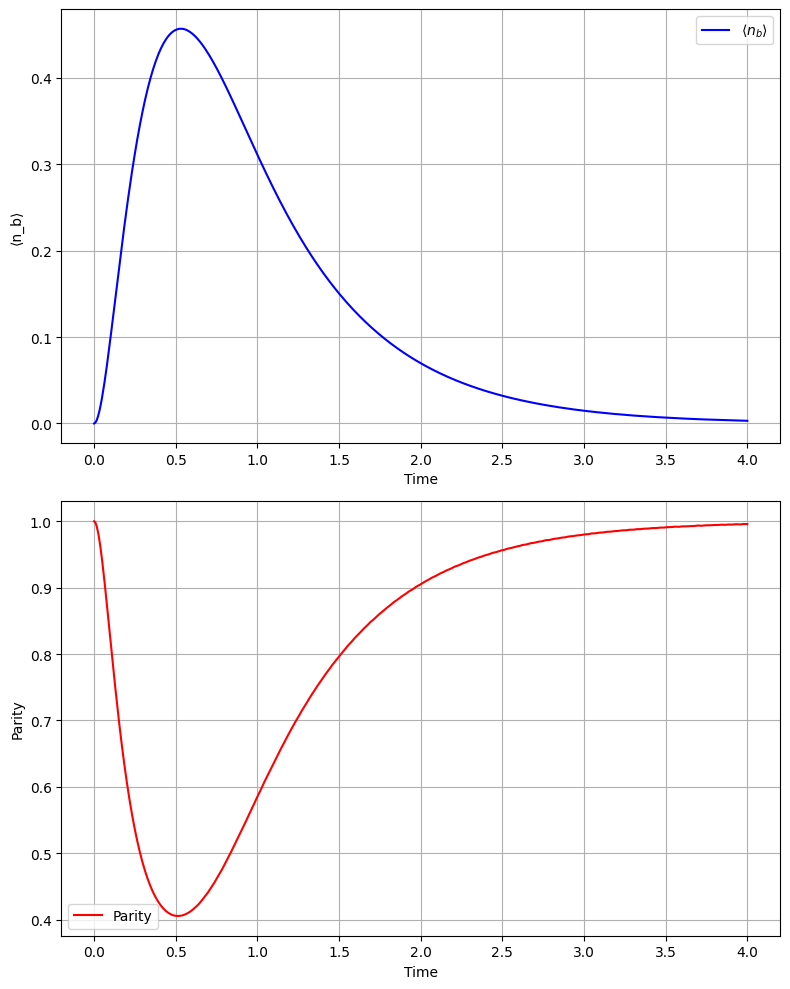

In [5]:
import dynamiqs as dq
import jax.numpy as jnp       
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from functools import reduce

# Hilbert-space truncations
na = 20   # Mode a (buffer)
nb = 5    # Mode b (memory)

# Operators in the composite Hilbert space
a    = dq.tensor(dq.destroy(na), dq.eye(nb))   # Mode a annihilation operator
adag = a.dag()                                  # Mode a creation operator
b    = dq.tensor(dq.eye(na), dq.destroy(nb))    # Mode b annihilation operator
bdag = b.dag()                                  # Mode b creation operator

# Other parameters
g_2    = 1.0
eps_d  = -4.0
kappa_b = 10

# Hamiltonian construction
# Two-photon term: H^2ph = g_2 * a†^2 * b + g_2* * a^2 * b†
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)
# Drive term: H^d = eps_d* * b + eps_d * b†
H_d   = jnp.conjugate(eps_d) * b + eps_d * bdag
# Total Hamiltonian
H = H_2ph + H_d

# Initial state: both modes in the vacuum state.
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))

# Time array and collapse operator
T = 4
t_save = jnp.linspace(0, T, 500)
c_ops = [jnp.sqrt(kappa_b) * b]

# Solve the master equation
res = dq.mesolve(H, c_ops, psi0, t_save)

# Compute expectation values for mode b
# Photon number operator for mode b.
n_b = bdag @ b

# Build the parity operator for mode b.
# Construct the operator: Π_b = Σₙ (-1)^n |n⟩⟨n|
terms = [ (-1)**n * dq.fock_dm(nb, n) for n in range(nb) ]
parity_b_local = reduce(lambda X, Y: X + Y, terms)
parity_b = dq.tensor(dq.eye(na), parity_b_local)

# Compute expectation values over time.
n_b_expect = [dq.expect(n_b, state) for state in res.states]
parity_b_expect = [dq.expect(parity_b, state) for state in res.states]

# Animate the Wigner function for mode a
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))

def update(frame):
    ax_w.cla()  # Clear the axis.
    # Obtain the reduced state of mode a. (Use dq.ptrace if available.)
    # Here we assume dq.unit returns the state in mode a.
    rho_a = dq.unit(res.states[frame])
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Mode a Wigner Function\nTime = {t_save[frame]:.2f}")

ani = animation.FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_mode_a.gif'
ani.save(gif_filename, writer=PillowWriter(fps=1000))
plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))

# Plot the expectation value and parity for mode b
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(t_save, n_b_expect, label=r'$\langle n_b \rangle$', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('⟨n_b⟩')
ax1.legend()
ax1.grid(True)

ax2.plot(t_save, parity_b_expect, label='Parity', color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [6]:
import dynamiqs as dq
import jax.numpy as jnp       
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from functools import reduce

# ============================================================================
# Task 1.1: Simulate two-mode dynamics and compute observables
# ============================================================================

# -- Hilbert-space truncations --
na = 20   # Memory mode (stores the cat qubit)
nb = 5    # Buffer mode (dissipative, lossy)

# -- Define operators in the composite Hilbert space --
# Here, we work on the tensor product: memory (mode a) ⊗ buffer (mode b)
a    = dq.tensor(dq.destroy(na), dq.eye(nb))   # Memory mode annihilation operator
adag = a.dag()                                  # Memory mode creation operator
b    = dq.tensor(dq.eye(na), dq.destroy(nb))    # Buffer mode annihilation operator
bdag = b.dag()                                  # Buffer mode creation operator

# -- Define system parameters --
g2    = 1.0           # two-photon coupling constant (g₂)
eps_d = -4.0          # buffer drive amplitude (ϵ_d)
kappa_b = 10          # buffer decay rate (κ_b)

# -- Construct the Hamiltonian parts --
# Two-photon exchange Hamiltonian:
#   H^(2ph) = g2 * a†² * b + g2* * a² * b†
H_2ph = g2 * (adag @ adag @ b) + jnp.conjugate(g2) * (a @ a @ bdag)

# Buffer drive Hamiltonian:
#   H^d = eps_d* * b + eps_d * b†
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag

# Total Hamiltonian for the two-mode system:
H = H_2ph + H_d

# -- Initial state: vacuum in both modes --
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))

# -- Time array and collapse operator --
T = 4.0
t_save = jnp.linspace(0, T, 1000)
# Only the buffer mode is lossy; collapse operator on b:
c_ops = [jnp.sqrt(kappa_b) * b]

# -- Solve the master equation --
res = dq.mesolve(H, c_ops, psi0, t_save)

# -- Compute observables for the memory mode (mode a) --
# Photon number operator in memory:
n_a = adag @ a  # Expectation value ⟨n_a⟩

# For parity in the memory mode, construct:
#   Π_a = Σₙ (-1)^n |n⟩⟨n|
terms = [ (-1)**n * dq.fock_dm(na, n) for n in range(na) ]
parity_a_op = reduce(lambda X, Y: X + Y, terms)

# Since our full state is defined on (a ⊗ b) space, we take the tensor product
# with identity on the buffer mode to get the full memory parity operator:
parity_a = dq.tensor(parity_a_op, dq.eye(nb))

# Compute the expectation values over time.
n_a_expect = [ dq.expect(n_a, dq.ptrace(state, 0)) for state in res.states ]
parity_a_expect = [ dq.expect(parity_a, state) for state in res.states ]

# -- Animate the Wigner function of the memory mode (mode a) --
# (We assume dq.ptrace(state, 0) returns the reduced density matrix of mode a.)
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))
def update(frame):
    ax_w.cla()  # Clear previous frame
    rho_a = dq.ptrace(res.states[frame], 0)
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Memory mode Wigner function\nTime = {t_save[frame]:.2f}")
ani = animation.FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_memory_mode.gif'
ani.save(gif_filename, writer=PillowWriter(fps=25))
plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))

# -- Plot observables for memory mode (photon number and parity) --
fig_obs, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.plot(t_save, n_a_expect, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('⟨n_a⟩')
ax1.set_title('Photon Number in Memory Mode')
ax1.grid(True)
ax2.plot(t_save, parity_a_expect, color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parity')
ax2.set_title('Photon Number Parity in Memory Mode')
ax2.grid(True)
plt.tight_layout()
plt.show()


|██████████| 100.0% ◆ elapsed 253.49ms ◆ remaining 0.00ms  


TypeError: mul got incompatible shapes for broadcasting: (100, 100), (20, 20).